In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_squared_error
import cv2

# Data Loading and Preprocessing
filepath = '/home/tbranno/Downloads/train.npz'
data = np.load(filepath)
input_raw = data['input_raw_data']
num_seq = 100
subset_raw = input_raw[:num_seq * 20]
time_values = np.array([20000, 25000, 30000, 35000, 37500, 40000, 45000, 53000, 75000, 108000, 175000, 210000,
                        257000, 280000, 320000, 340000, 430000, 540000, 900000, 1080000])

def comp_grain_size(image):
    _, binary = cv2.threshold((image*255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours if cv2.contourArea(cnt) > 5]
    return np.mean(areas) if areas else 1e-6

all_grain_size = np.zeros((num_seq, 20))
for seq in range(num_seq):
    seq_images = subset_raw[seq * 20:(seq + 1) * 20, 0, :, :]
    grain_size = np.array([comp_grain_size(img) for img in seq_images])
    first_grain_size = max(grain_size[0], 1)
    all_grain_size[seq] = grain_size / first_grain_size

x_time_log = np.tile(np.log(time_values), num_seq)
y_grain_sizes = all_grain_size.flatten()

# Outlier removal
Q1, Q3 = np.percentile(y_grain_sizes, 25), np.percentile(y_grain_sizes, 75)
IQR = Q3 - Q1
l_bound, u_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
allowed = (y_grain_sizes >= l_bound) & (y_grain_sizes <= u_bound)
X = x_time_log[allowed].reshape(-1, 1)
y = y_grain_sizes[allowed]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

2025-04-09 11:19:59.754557: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 11:20:01.915968: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 11:20:02.521756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744212003.012448 1225790 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744212003.072237 1225790 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744212003.961676 1225790 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin


Training ANN with 80% train / 19% test split:


/home/tbranno/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-09 11:20:42.898541: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


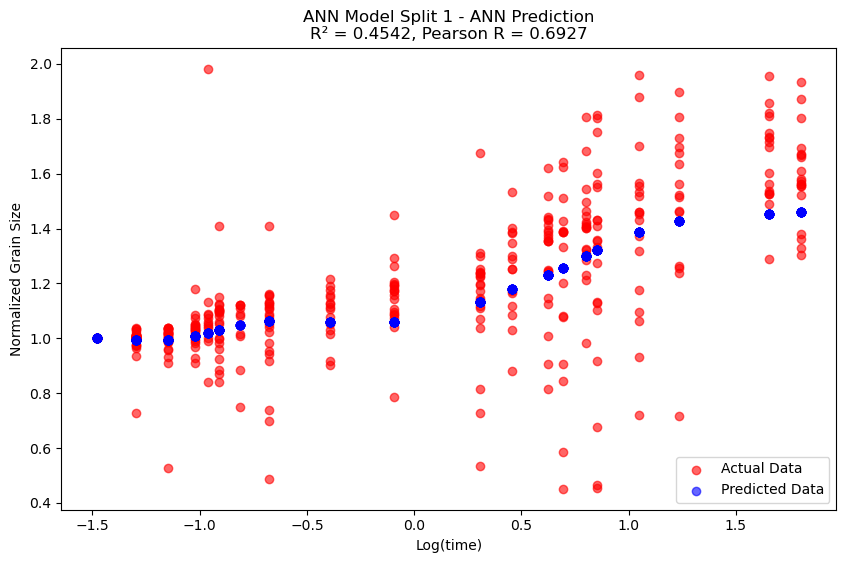


Training ANN with 70% train / 30% test split:


/home/tbranno/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


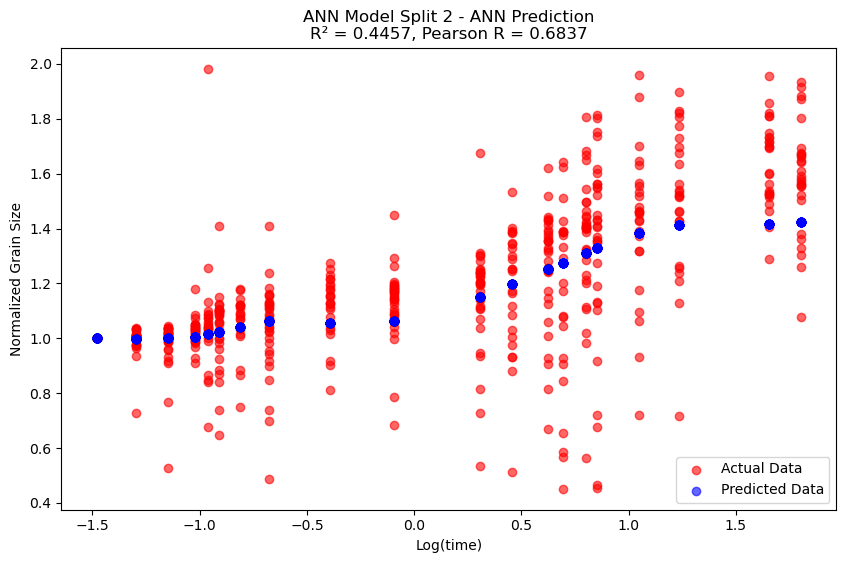


Training ANN with 60% train / 40% test split:


/home/tbranno/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


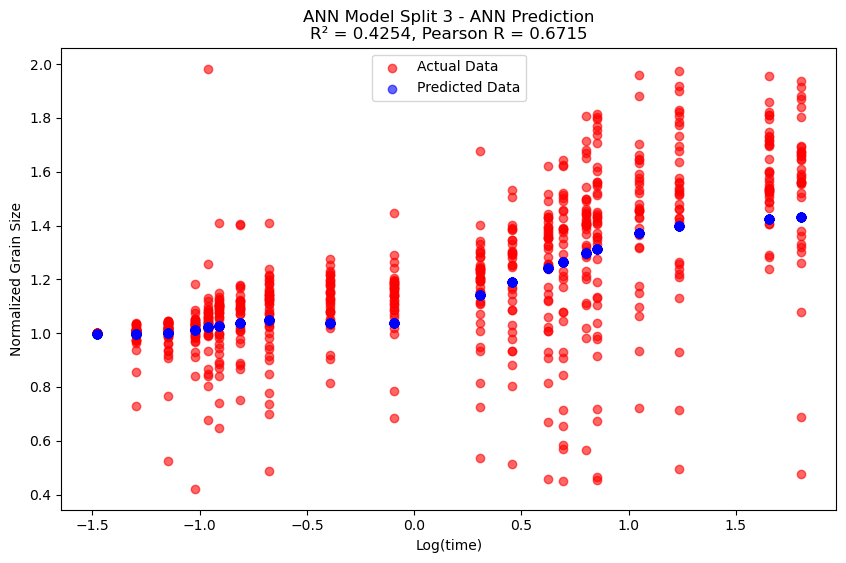


Summary of Results for Different Splits:
Split 1: Train 80% / Test 19% → R²: 0.4542, Pearson R: 0.6927
Split 2: Train 70% / Test 30% → R²: 0.4457, Pearson R: 0.6837
Split 3: Train 60% / Test 40% → R²: 0.4254, Pearson R: 0.6715


In [2]:
# Function to build and train ANN
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

def build_and_train_ann(X_train, y_train, X_test, y_test, title):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=1))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
    
    y_pred = model.predict(X_test).flatten()
    
    # Calculate R² and Pearson's r
    r2 = r2_score(y_test, y_pred)
    r_val, _ = pearsonr(y_test, y_pred)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test, y_test, color='red', alpha=0.6, label='Actual Data')
    plt.scatter(X_test, y_pred, color='blue', alpha=0.6, label='Predicted Data')
    plt.xlabel("Log(time)")
    plt.ylabel("Normalized Grain Size")
    plt.title(f"{title} - ANN Prediction\nR² = {r2:.4f}, Pearson R = {r_val:.4f}")
    plt.legend()
    plt.show()
    
    return r2, r_val

# Try three different splits
splits = [(0.8, 0.2), (0.7, 0.3), (0.6, 0.4)]
results = []

for i, (train_size, test_size) in enumerate(splits):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=train_size, test_size=1-train_size, random_state=42)
    print(f"\nTraining ANN with {int(train_size*100)}% train / {int((1-train_size)*100)}% test split:")
    r2, r_val = build_and_train_ann(X_train, y_train, X_test, y_test, f"ANN Model Split {i+1}")
    results.append((train_size, r2, r_val))

# Print comparison of all splits
print("\nSummary of Results for Different Splits:")
for i, (train_size, r2, r_val) in enumerate(results):
    print(f"Split {i+1}: Train {int(train_size*100)}% / Test {int((1-train_size)*100)}% → R²: {r2:.4f}, Pearson R: {r_val:.4f}")